# PI World 2018 Lab: Fit for Purpose - Layers of Analytics using the PI System – AF, MATLAB, Machine Learning

![](dryer-exercise1.png)

## [Click here for the full lab PDF guide](./PI-World-2018_Fit-for-Purpose_Layers-of-Analytics-using-the-PI-System.pdf)

### Warning: the following cell takes quite a long time (many minutes) to install the missing packages

In [1]:
# Install and load packages
library(RCurl)
library(readxl)
library(ggplot2)
#library(gsubfn)
options(gsubfn.engine = "R")
library(sqldf)
suppressMessages(library(MESS))
library(MESS)
suppressMessages(library(dplyr))
library(dplyr)

Loading required package: bitops
Installing package into ‘/usr/local/spark-2.4.0-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
also installing the dependencies ‘bit’, ‘bit64’, ‘blob’, ‘memoise’, ‘gsubfn’, ‘proto’, ‘RSQLite’, ‘chron’

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Installing package into ‘/usr/local/spark-2.4.0-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
also installing the dependencies ‘codetools’, ‘iterators’, ‘foreach’, ‘quadprog’, ‘geepack’, ‘geeM’, ‘glmnet’, ‘kinship2’, ‘mvtnorm’, ‘RcppArmadillo’



In [2]:
# read the excel file containing the start and end time of the event frames (step 1)
time<- read_excel("retrievedataforlab1(174).xlsx")

In [3]:
# we convert the list (time) into a data frame (step 1)
time<-as.data.frame(time)
start.time<- time$StartTime
end.time<- time$EndTime

In [4]:
start.time

  [1] "2017-01-02 00:00:00 UTC" "2017-01-02 19:00:00 UTC"
  [3] "2017-01-03 21:18:00 UTC" "2017-01-04 22:54:00 UTC"
  [5] "2017-01-05 19:54:00 UTC" "2017-01-06 20:54:00 UTC"
  [7] "2017-01-07 21:06:00 UTC" "2017-01-08 22:24:00 UTC"
  [9] "2017-01-10 03:12:00 UTC" "2017-01-11 02:36:00 UTC"
 [11] "2017-01-12 04:18:00 UTC" "2017-01-13 03:00:00 UTC"
 [13] "2017-01-14 13:30:00 UTC" "2017-01-15 17:24:00 UTC"
 [15] "2017-01-16 21:42:00 UTC" "2017-01-17 23:30:00 UTC"
 [17] "2017-01-19 02:24:00 UTC" "2017-01-20 06:30:00 UTC"
 [19] "2017-01-21 15:36:00 UTC" "2017-01-23 01:30:00 UTC"
 [21] "2017-01-24 07:42:00 UTC" "2017-01-25 08:48:00 UTC"
 [23] "2017-01-26 11:18:00 UTC" "2017-01-27 15:06:00 UTC"
 [25] "2017-01-28 18:00:00 UTC" "2017-01-29 19:06:00 UTC"
 [27] "2017-01-30 21:30:00 UTC" "2017-01-31 22:06:00 UTC"
 [29] "2017-02-02 00:30:00 UTC" "2017-02-03 01:18:00 UTC"
 [31] "2017-02-04 22:00:00 UTC" "2017-02-06 23:36:00 UTC"
 [33] "2017-02-08 22:54:00 UTC" "2017-02-11 06:12:00 UTC"
 [35] "2017-02

In [5]:
end.time

  [1] "2017-01-02 05:18:00 UTC" "2017-01-03 06:18:00 UTC"
  [3] "2017-01-04 06:54:00 UTC" "2017-01-05 07:42:00 UTC"
  [5] "2017-01-06 04:00:00 UTC" "2017-01-07 04:30:00 UTC"
  [7] "2017-01-08 06:42:00 UTC" "2017-01-09 09:18:00 UTC"
  [9] "2017-01-10 13:18:00 UTC" "2017-01-11 13:12:00 UTC"
 [11] "2017-01-12 13:54:00 UTC" "2017-01-13 22:30:00 UTC"
 [13] "2017-01-14 23:06:00 UTC" "2017-01-16 03:18:00 UTC"
 [15] "2017-01-17 09:24:00 UTC" "2017-01-18 10:42:00 UTC"
 [17] "2017-01-19 13:06:00 UTC" "2017-01-20 22:24:00 UTC"
 [19] "2017-01-22 03:18:00 UTC" "2017-01-23 14:12:00 UTC"
 [21] "2017-01-24 17:12:00 UTC" "2017-01-25 19:06:00 UTC"
 [23] "2017-01-26 21:24:00 UTC" "2017-01-28 01:24:00 UTC"
 [25] "2017-01-29 04:42:00 UTC" "2017-01-30 05:36:00 UTC"
 [27] "2017-01-31 08:36:00 UTC" "2017-02-01 09:30:00 UTC"
 [29] "2017-02-02 11:12:00 UTC" "2017-02-03 11:00:00 UTC"
 [31] "2017-02-05 11:00:00 UTC" "2017-02-07 14:00:00 UTC"
 [33] "2017-02-09 10:36:00 UTC" "2017-02-11 18:00:00 UTC"
 [35] "2017-02

In [14]:
# reformat the time format to month-day-year (step 1)
l<-format(start.time,"%m/%d/%Y %H:%M:%S")

In [15]:
# reformat the time format to month-day-year (step 1)
m<-format(end.time,"%m/%d/%Y %H:%M:%S")

### The cell below calls Academic Hub to remove the engine information of interest (takes a few minutes to run)

In [16]:
#intitiate here with a vector of length 20 because it is the number of column in our data frame (step 1)
C<-numeric(20) 
# Use for loop to collect the data for 100 engines from the OSIsoft Academic Hub;
for ( i in 1:length(start.time)) {
    # S and E are equal to indices of the start and end time respectively.
S<-l[i] 
E<-m[i]
    # Formatting URL and header options for data-pull request
controller.url <- "https://academicpi.azure-api.net/hub/api/Csv/ElementInterpolated"
element.path <- paste("?path=\\\\PIAF-ACAD\\ Dryers\\Dryer A&startTime=",S,"&endTime=",E, "&interval=6m")
    
    # Create the url by combining the controller to the element path.
url  <- paste(controller.url, element.path, sep = "")
    # We need to encode the URL
encoded.url  <- URLencode(url)
      # We use the getURL function to call the PI Academic server and extract the data which is going to come in a csv format.
data.request  <- getURL(encoded.url,
                       ssl.verifypeer=FALSE,
                       ssl.verifyhost=FALSE,
                       userpwd = "reader0:OSIsoft2017",
                       httpauth=1L)


data.string<-data.request
    # Convert the data from the csv format to an organized Dataframe.
DataFrame<-as.data.frame(read.csv(text=data.string,header=TRUE))
C<-rbind(C,DataFrame)
}

Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(352.791198730469, 352.791198730469, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(909.945861816406, 909.945861816406, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(352.791198730469, 352.791198730469, 

In [17]:
dim(C) 
# Here we are only interested in specific columns of the data frame (step 1)
C<-C[2:nrow(C),c(1,2,9,10)]

[1] 29217    20

In [18]:
#View C
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
C

Element Timestamp            Outlet.Temperature Operating.State
2     Dryer A 2017-01-02T08:00:00Z 436.9              Regeneration   
3     Dryer A 2017-01-02T08:06:00Z 437.8              Regeneration   
4     Dryer A 2017-01-02T08:12:00Z 438.6              Regeneration   
5     Dryer A 2017-01-02T08:18:00Z 439.5              Regeneration   
6     Dryer A 2017-01-02T08:24:00Z 440.3              Regeneration   
7     Dryer A 2017-01-02T08:30:00Z 441.2              Regeneration   
8     Dryer A 2017-01-02T08:36:00Z 441.7              Regeneration   
9     Dryer A 2017-01-02T08:42:00Z 441.7              Regeneration   
10    Dryer A 2017-01-02T08:48:00Z 441.8              Regeneration   
11    Dryer A 2017-01-02T08:54:00Z 441.8              Regeneration   
12    Dryer A 2017-01-02T09:00:00Z 441.9              Regeneration   
13    Dryer A 2017-01-02T09:06:00Z 442.5              Regeneration   
14    Dryer A 2017-01-02T09:12:00Z 443.3              Regeneration   
15    Dryer A 2017-01-02T09:18:00Z 444.0              Regeneration   
16    Dryer A 2017-01-02T09:24:00Z 444.3              Regeneration   
17    Dryer A 2017-01-02T09:30:00Z 444.6              Regeneration   
18    Dryer A 2017-01-02T09:36:00Z 445.0              Regeneration   
19    Dryer A 2017-01-02T09:42:00Z 445.3              Regeneration   
20    Dryer A 2017-01-02T09:48:00Z 445.6              Regeneration   
21    Dryer A 2017-01-02T09:54:00Z 445.9              Regeneration   
22    Dryer A 2017-01-02T10:00:00Z 446.1              Regeneration   
23    Dryer A 2017-01-02T10:06:00Z 445.7              Regeneration   
24    Dryer A 2017-01-02T10:12:00Z 443.4              Regeneration   
25    Dryer A 2017-01-02T10:18:00Z 420.9              Regeneration   
26    Dryer A 2017-01-02T10:24:00Z 380.4              Regeneration   
27    Dryer A 2017-01-02T10:30:00Z 348.8              Regeneration   
28    Dryer A 2017-01-02T10:36:00Z 320.0              Regeneration   
29    Dryer A 2017-01-02T10:42:00Z 295.8              Regeneration   
30    Dryer A 2017-01-02T10:48:00Z 276.7              Regeneration   
31    Dryer A 2017-01-02T10:54:00Z 258.1              Regeneration   
32    Dryer A 2017-01-02T11:00:00Z 244.3              Regeneration   
33    Dryer A 2017-01-02T11:06:00Z 235.3              Regeneration   
34    Dryer A 2017-01-02T11:12:00Z 228.8              Regeneration   
35    Dryer A 2017-01-02T11:18:00Z 222.6              Regeneration   
36    Dryer A 2017-01-02T11:24:00Z 216.8              Regeneration   
37    Dryer A 2017-01-02T11:30:00Z 212.3              Regeneration   
38    Dryer A 2017-01-02T11:36:00Z 210.0              Regeneration   
39    Dryer A 2017-01-02T11:42:00Z 206.1              Regeneration   
40    Dryer A 2017-01-02T11:48:00Z 202.7              Regeneration   
41    Dryer A 2017-01-02T11:54:00Z 200.5              Regeneration   
42    Dryer A 2017-01-02T12:00:00Z 198.3              Regeneration   
43    Dryer A 2017-01-02T12:06:00Z 196.1              Regeneration   
44    Dryer A 2017-01-02T12:12:00Z 194.0              Regeneration   
45    Dryer A 2017-01-02T12:18:00Z 191.8              Regeneration   
46    Dryer A 2017-01-02T12:24:00Z 189.6              Regeneration   
47    Dryer A 2017-01-02T12:30:00Z 187.4              Regeneration   
48    Dryer A 2017-01-02T12:36:00Z 185.2              Regeneration   
49    Dryer A 2017-01-02T12:42:00Z 184.0              Regeneration   
50    Dryer A 2017-01-02T12:48:00Z 183.1              Regeneration   
51    Dryer A 2017-01-02T12:54:00Z 181.7              Regeneration   
52    Dryer A 2017-01-02T13:00:00Z 180.2              Regeneration   
53    Dryer A 2017-01-02T13:06:00Z 179.0              Regeneration   
54    Dryer A 2017-01-02T13:12:00Z 177.8              Regeneration   
55    Dryer A 2017-01-02T13:18:00Z 173.8              Process        
56    Dryer A 2017-01-03T03:00:00Z 170.0              Regeneration   
57    Dryer A 2017-01-03T03:06:00Z 170.1              Regeneration   
58    Dryer A 20

In [19]:
#We are going to create a column that correspond to the cycle where each cycle is defined by the start and the end of a regenration state.
C$Cycle=0
k=1
C$Cycle[1]=1
for(j in 2:(nrow(C)-1)) {
  if (C$Operating.State[j]== C$Operating.State[j-1]){
    C$Cycle[j]=k
  }
  else {
    if(C$Operating.State[j]=="Regeneration" & C$Operating.State[j-1]=="Process"){
      k=k+1
     C$Cycle[j]=k
    }
    else {
    k=k
    C$Cycle[j]=k
  }
  }
}
max(C$Cycle)

[1] 212

In [20]:
# matching each data point with its respective start time. 
C$start.time=as.character(0)
k=1
C$start.time[1]=as.character(start.time[k])
for(j in 2:(nrow(C)-1)){
  if (C$Operating.State[j]== C$Operating.State[j-1]){
    k=k
    C$start.time[j]=as.character(start.time[k])
    
  }
  else {
    if (C$Operating.State[j]=="Regeneration" & C$Operating.State[j-1]=="Process"){
      k=k+1
     C$start.time[j]=as.character(start.time[k])
    }
    else {
      k=k
      C$start.time[j]=as.character(start.time[k])
    }
    }
}

In [21]:
#  Similarly, matching each data point with its respective end time. 
C$end.time=as.character(0)
k=1
C$end.time[1]=as.character(end.time[k])
for(j in 2:(nrow(C)-1)){
  if (C$Operating.State[j]== C$Operating.State[j-1]){
    k=k
    C$end.time[j]=as.character(end.time[k])
    
  }
  else {
    if (C$Operating.State[j]=="Regeneration" & C$Operating.State[j-1]=="Process"){
      k=k+1
      C$end.time[j]=as.character(end.time[k])
    }
    else {
      k=k
      C$end.time[j]=as.character(end.time[k])
    }
  }
}


In [22]:
# Only take the data points for the 193 first event frames as suggested in the write-up
C<-C[1:22416,]
C

Element Timestamp            Outlet.Temperature Operating.State Cycle
2     Dryer A 2017-01-02T08:00:00Z 436.9              Regeneration    1    
3     Dryer A 2017-01-02T08:06:00Z 437.8              Regeneration    1    
4     Dryer A 2017-01-02T08:12:00Z 438.6              Regeneration    1    
5     Dryer A 2017-01-02T08:18:00Z 439.5              Regeneration    1    
6     Dryer A 2017-01-02T08:24:00Z 440.3              Regeneration    1    
7     Dryer A 2017-01-02T08:30:00Z 441.2              Regeneration    1    
8     Dryer A 2017-01-02T08:36:00Z 441.7              Regeneration    1    
9     Dryer A 2017-01-02T08:42:00Z 441.7              Regeneration    1    
10    Dryer A 2017-01-02T08:48:00Z 441.8              Regeneration    1    
11    Dryer A 2017-01-02T08:54:00Z 441.8              Regeneration    1    
12    Dryer A 2017-01-02T09:00:00Z 441.9              Regeneration    1    
13    Dryer A 2017-01-02T09:06:00Z 442.5              Regeneration    1    
14    Dryer A 2017-01-02T09:12:00Z 443.3              Regeneration    1    
15    Dryer A 2017-01-02T09:18:00Z 444.0              Regeneration    1    
16    Dryer A 2017-01-02T09:24:00Z 444.3              Regeneration    1    
17    Dryer A 2017-01-02T09:30:00Z 444.6              Regeneration    1    
18    Dryer A 2017-01-02T09:36:00Z 445.0              Regeneration    1    
19    Dryer A 2017-01-02T09:42:00Z 445.3              Regeneration    1    
20    Dryer A 2017-01-02T09:48:00Z 445.6              Regeneration    1    
21    Dryer A 2017-01-02T09:54:00Z 445.9              Regeneration    1    
22    Dryer A 2017-01-02T10:00:00Z 446.1              Regeneration    1    
23    Dryer A 2017-01-02T10:06:00Z 445.7              Regeneration    1    
24    Dryer A 2017-01-02T10:12:00Z 443.4              Regeneration    1    
25    Dryer A 2017-01-02T10:18:00Z 420.9              Regeneration    1    
26    Dryer A 2017-01-02T10:24:00Z 380.4              Regeneration    1    
27    Dryer A 2017-01-02T10:30:00Z 348.8              Regeneration    1    
28    Dryer A 2017-01-02T10:36:00Z 320.0              Regeneration    1    
29    Dryer A 2017-01-02T10:42:00Z 295.8              Regeneration    1    
30    Dryer A 2017-01-02T10:48:00Z 276.7              Regeneration    1    
31    Dryer A 2017-01-02T10:54:00Z 258.1              Regeneration    1    
32    Dryer A 2017-01-02T11:00:00Z 244.3              Regeneration    1    
33    Dryer A 2017-01-02T11:06:00Z 235.3              Regeneration    1    
34    Dryer A 2017-01-02T11:12:00Z 228.8              Regeneration    1    
35    Dryer A 2017-01-02T11:18:00Z 222.6              Regeneration    1    
36    Dryer A 2017-01-02T11:24:00Z 216.8              Regeneration    1    
37    Dryer A 2017-01-02T11:30:00Z 212.3              Regeneration    1    
38    Dryer A 2017-01-02T11:36:00Z 210.0              Regeneration    1    
39    Dryer A 2017-01-02T11:42:00Z 206.1              Regeneration    1    
40    Dryer A 2017-01-02T11:48:00Z 202.7              Regeneration    1    
41    Dryer A 2017-01-02T11:54:00Z 200.5              Regeneration    1    
42    Dryer A 2017-01-02T12:00:00Z 198.3              Regeneration    1    
43    Dryer A 2017-01-02T12:06:00Z 196.1              Regeneration    1    
44    Dryer A 2017-01-02T12:12:00Z 194.0              Regeneration    1    
45    Dryer A 2017-01-02T12:18:00Z 191.8              Regeneration    1    
46    Dryer A 2017-01-02T12:24:00Z 189.6              Regeneration    1    
47    Dryer A 2017-01-02T12:30:00Z 187.4              Regeneration    1    
48    Dryer A 2017-01-02T12:36:00Z 185.2              Regeneration    1    
49    Dryer A 2017-01-02T12:42:00Z 184.0              Regeneration    1    
50    Dryer A 2017-01-02T12:48:00Z 183.1              Regeneration    1    
51    Dryer A 2017-01-02T12:54:00Z 181.7              Regeneration    1    
52    Dryer A 2017-01-02T13:00:00Z 180.2              Regeneration    1    
53    Dryer A 2017-01-02T13:06:00Z 179.0              

In [23]:
# We have to create an elapsed time vector. (step 2)
elapsedtime <- numeric(nrow(C))
# gsub is used to remove the "T" and "z" characters.
sub<-gsub("T"," ",C$Timestamp) 
sub<-gsub("Z","",sub)

# for loop was built to form the elapsed time vector.
for(z in 2: (nrow(C))) {
    # create time1 and time 2 which are here date-time type. So the goal was to convert from character to a date.time variable.
  time1<- strptime(sub[z],format="%Y-%m-%d %H:%M:%S") 
  time2<- strptime(sub[z-1],format="%Y-%m-%d %H:%M:%S")
  if (C$Cycle[z]== C$Cycle[z-1]){
  # varia is a  difference in time
 varia<-data.frame(time1-time2)
# we also remove the character "hours" and "time difference of" from varia and make it a number.
 varia<-gsub("Time difference of ","",varia) 
varia<-gsub("hours","",varia)
# varia is a character so we need to convert it to a number.
varia<- as.numeric(as.character(varia))
elapsedtime[z]<- varia + elapsedtime[z-1] # we are building the elapsedtime vecotr.
  }
 
    else {
    # elapsedtime goes back to zero at the start of every new cycle.
      elapsedtime[z]=0
    }
  }
# we add the elapsed time vector as an extra column at the end of the C data frame.
C["elapsedtime"]<-elapsedtime
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
C

Element Timestamp            Outlet.Temperature Operating.State Cycle
2     Dryer A 2017-01-02T08:00:00Z 436.9              Regeneration    1    
3     Dryer A 2017-01-02T08:06:00Z 437.8              Regeneration    1    
4     Dryer A 2017-01-02T08:12:00Z 438.6              Regeneration    1    
5     Dryer A 2017-01-02T08:18:00Z 439.5              Regeneration    1    
6     Dryer A 2017-01-02T08:24:00Z 440.3              Regeneration    1    
7     Dryer A 2017-01-02T08:30:00Z 441.2              Regeneration    1    
8     Dryer A 2017-01-02T08:36:00Z 441.7              Regeneration    1    
9     Dryer A 2017-01-02T08:42:00Z 441.7              Regeneration    1    
10    Dryer A 2017-01-02T08:48:00Z 441.8              Regeneration    1    
11    Dryer A 2017-01-02T08:54:00Z 441.8              Regeneration    1    
12    Dryer A 2017-01-02T09:00:00Z 441.9              Regeneration    1    
13    Dryer A 2017-01-02T09:06:00Z 442.5              Regeneration    1    
14    Dryer A 2017-01-02T09:12:00Z 443.3              Regeneration    1    
15    Dryer A 2017-01-02T09:18:00Z 444.0              Regeneration    1    
16    Dryer A 2017-01-02T09:24:00Z 444.3              Regeneration    1    
17    Dryer A 2017-01-02T09:30:00Z 444.6              Regeneration    1    
18    Dryer A 2017-01-02T09:36:00Z 445.0              Regeneration    1    
19    Dryer A 2017-01-02T09:42:00Z 445.3              Regeneration    1    
20    Dryer A 2017-01-02T09:48:00Z 445.6              Regeneration    1    
21    Dryer A 2017-01-02T09:54:00Z 445.9              Regeneration    1    
22    Dryer A 2017-01-02T10:00:00Z 446.1              Regeneration    1    
23    Dryer A 2017-01-02T10:06:00Z 445.7              Regeneration    1    
24    Dryer A 2017-01-02T10:12:00Z 443.4              Regeneration    1    
25    Dryer A 2017-01-02T10:18:00Z 420.9              Regeneration    1    
26    Dryer A 2017-01-02T10:24:00Z 380.4              Regeneration    1    
27    Dryer A 2017-01-02T10:30:00Z 348.8              Regeneration    1    
28    Dryer A 2017-01-02T10:36:00Z 320.0              Regeneration    1    
29    Dryer A 2017-01-02T10:42:00Z 295.8              Regeneration    1    
30    Dryer A 2017-01-02T10:48:00Z 276.7              Regeneration    1    
31    Dryer A 2017-01-02T10:54:00Z 258.1              Regeneration    1    
32    Dryer A 2017-01-02T11:00:00Z 244.3              Regeneration    1    
33    Dryer A 2017-01-02T11:06:00Z 235.3              Regeneration    1    
34    Dryer A 2017-01-02T11:12:00Z 228.8              Regeneration    1    
35    Dryer A 2017-01-02T11:18:00Z 222.6              Regeneration    1    
36    Dryer A 2017-01-02T11:24:00Z 216.8              Regeneration    1    
37    Dryer A 2017-01-02T11:30:00Z 212.3              Regeneration    1    
38    Dryer A 2017-01-02T11:36:00Z 210.0              Regeneration    1    
39    Dryer A 2017-01-02T11:42:00Z 206.1              Regeneration    1    
40    Dryer A 2017-01-02T11:48:00Z 202.7              Regeneration    1    
41    Dryer A 2017-01-02T11:54:00Z 200.5              Regeneration    1    
42    Dryer A 2017-01-02T12:00:00Z 198.3              Regeneration    1    
43    Dryer A 2017-01-02T12:06:00Z 196.1              Regeneration    1    
44    Dryer A 2017-01-02T12:12:00Z 194.0              Regeneration    1    
45    Dryer A 2017-01-02T12:18:00Z 191.8              Regeneration    1    
46    Dryer A 2017-01-02T12:24:00Z 189.6              Regeneration    1    
47    Dryer A 2017-01-02T12:30:00Z 187.4              Regeneration    1    
48    Dryer A 2017-01-02T12:36:00Z 185.2              Regeneration    1    
49    Dryer A 2017-01-02T12:42:00Z 184.0              Regeneration    1    
50    Dryer A 2017-01-02T12:48:00Z 183.1              Regeneration    1    
51    Dryer A 2017-01-02T12:54:00Z 181.7              Regeneration    1    
52    Dryer A 2017-01-02T13:00:00Z 180.2              Regeneration    1    
53    Dryer A 2017-01-02T13:06:00Z 179.0              

In [24]:
# making the name of Outlet.Temperature easier. (step 2)
C$T<-C$Outlet.Temperature

Warning message:
“Removed 10803 rows containing missing values (geom_path).”Warning message:
“Removed 10803 rows containing missing values (geom_path).”

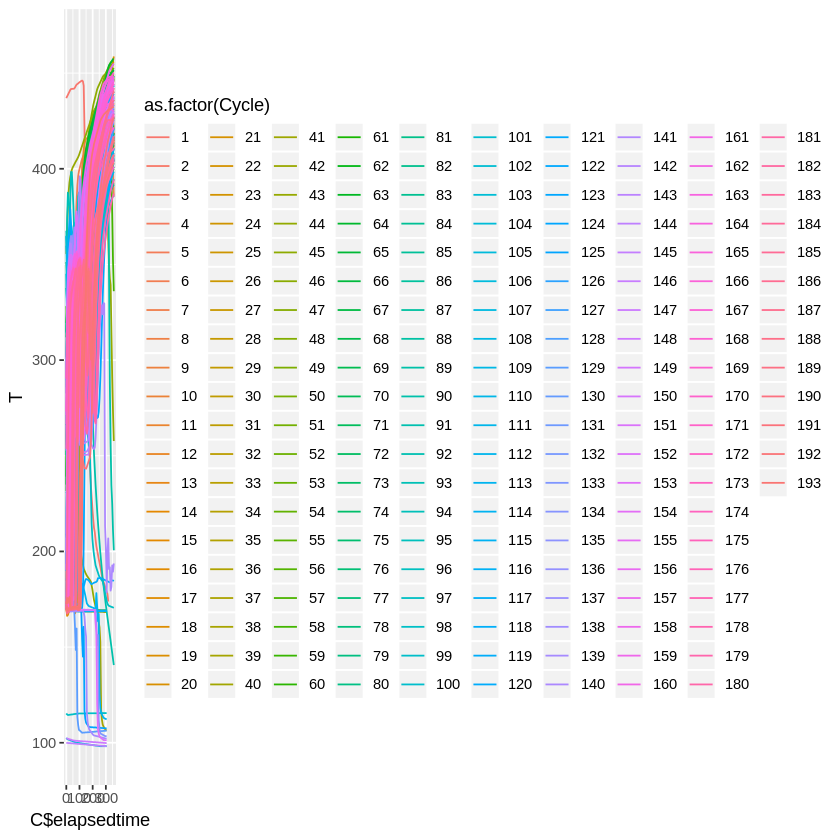

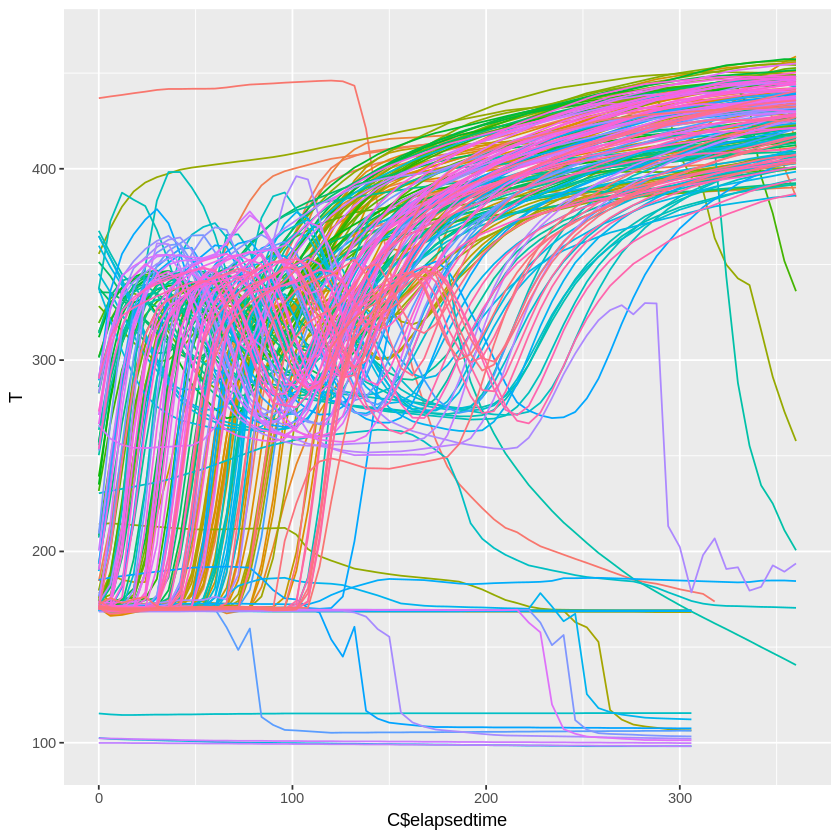

In [25]:
library("ggplot2") #(step2)
require("ggplot2")
elapsedtime<-C$elapsedtime
#Plot temperature vs Time
ggplot (data=C)+aes(x=C$elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+xlim(0,360)
ggplot (data=C)+aes(x=C$elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+theme(legend.position='none')+xlim(0,360)

In [26]:
# Subset data to keep record with T>200; (step 3)
C1<-subset(C,C$T>200)
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
C1

Element Timestamp            Outlet.Temperature Operating.State Cycle
2     Dryer A 2017-01-02T08:00:00Z 436.9              Regeneration    1    
3     Dryer A 2017-01-02T08:06:00Z 437.8              Regeneration    1    
4     Dryer A 2017-01-02T08:12:00Z 438.6              Regeneration    1    
5     Dryer A 2017-01-02T08:18:00Z 439.5              Regeneration    1    
6     Dryer A 2017-01-02T08:24:00Z 440.3              Regeneration    1    
7     Dryer A 2017-01-02T08:30:00Z 441.2              Regeneration    1    
8     Dryer A 2017-01-02T08:36:00Z 441.7              Regeneration    1    
9     Dryer A 2017-01-02T08:42:00Z 441.7              Regeneration    1    
10    Dryer A 2017-01-02T08:48:00Z 441.8              Regeneration    1    
11    Dryer A 2017-01-02T08:54:00Z 441.8              Regeneration    1    
12    Dryer A 2017-01-02T09:00:00Z 441.9              Regeneration    1    
13    Dryer A 2017-01-02T09:06:00Z 442.5              Regeneration    1    
14    Dryer A 2017-01-02T09:12:00Z 443.3              Regeneration    1    
15    Dryer A 2017-01-02T09:18:00Z 444.0              Regeneration    1    
16    Dryer A 2017-01-02T09:24:00Z 444.3              Regeneration    1    
17    Dryer A 2017-01-02T09:30:00Z 444.6              Regeneration    1    
18    Dryer A 2017-01-02T09:36:00Z 445.0              Regeneration    1    
19    Dryer A 2017-01-02T09:42:00Z 445.3              Regeneration    1    
20    Dryer A 2017-01-02T09:48:00Z 445.6              Regeneration    1    
21    Dryer A 2017-01-02T09:54:00Z 445.9              Regeneration    1    
22    Dryer A 2017-01-02T10:00:00Z 446.1              Regeneration    1    
23    Dryer A 2017-01-02T10:06:00Z 445.7              Regeneration    1    
24    Dryer A 2017-01-02T10:12:00Z 443.4              Regeneration    1    
25    Dryer A 2017-01-02T10:18:00Z 420.9              Regeneration    1    
26    Dryer A 2017-01-02T10:24:00Z 380.4              Regeneration    1    
27    Dryer A 2017-01-02T10:30:00Z 348.8              Regeneration    1    
28    Dryer A 2017-01-02T10:36:00Z 320.0              Regeneration    1    
29    Dryer A 2017-01-02T10:42:00Z 295.8              Regeneration    1    
30    Dryer A 2017-01-02T10:48:00Z 276.7              Regeneration    1    
31    Dryer A 2017-01-02T10:54:00Z 258.1              Regeneration    1    
32    Dryer A 2017-01-02T11:00:00Z 244.3              Regeneration    1    
33    Dryer A 2017-01-02T11:06:00Z 235.3              Regeneration    1    
34    Dryer A 2017-01-02T11:12:00Z 228.8              Regeneration    1    
35    Dryer A 2017-01-02T11:18:00Z 222.6              Regeneration    1    
36    Dryer A 2017-01-02T11:24:00Z 216.8              Regeneration    1    
37    Dryer A 2017-01-02T11:30:00Z 212.3              Regeneration    1    
38    Dryer A 2017-01-02T11:36:00Z 210.0              Regeneration    1    
39    Dryer A 2017-01-02T11:42:00Z 206.1              Regeneration    1    
40    Dryer A 2017-01-02T11:48:00Z 202.7              Regeneration    1    
41    Dryer A 2017-01-02T11:54:00Z 200.5              Regeneration    1    
68    Dryer A 2017-01-03T04:12:00Z 222.8              Regeneration    2    
69    Dryer A 2017-01-03T04:18:00Z 265.0              Regeneration    2    
70    Dryer A 2017-01-03T04:24:00Z 299.1              Regeneration    2    
71    Dryer A 2017-01-03T04:30:00Z 316.7              Regeneration    2    
72    Dryer A 2017-01-03T04:36:00Z 325.6              Regeneration    2    
73    Dryer A 2017-01-03T04:42:00Z 329.9              Regeneration    2    
74    Dryer A 2017-01-03T04:48:00Z 331.7              Regeneration    2    
75    Dryer A 2017-01-03T04:54:00Z 333.6              Regeneration    2    
76    Dryer A 2017-01-03T05:00:00Z 339.6              Regeneration    2    
77    Dryer A 2017-01-03T05:06:00Z 350.5              Regeneration    2    
78    Dryer A 2017-01-03T05:12:00Z 361.6              Regeneration    2    
79    Dryer A 2017-01-03T05:18:00Z 369.0              

Warning message:
“Removed 7271 rows containing missing values (geom_path).”

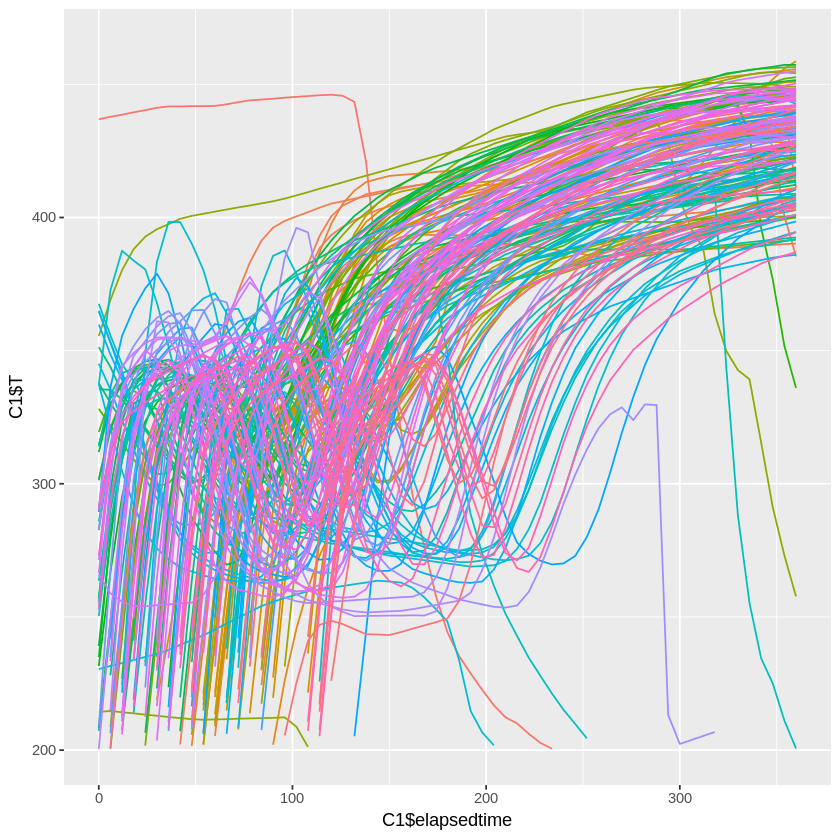

In [27]:
#Plot temperature vs Time (step 3)
ggplot(data=C1)+aes(x=C1$elapsedtime,y=C1$T)+geom_line(aes(color=as.factor(Cycle)))+theme(legend.position='none')+xlim(0,360)

In [28]:
C1$StartTime=C1$start.time
#line up start time to 0 (step 3)
elapsedtime <- numeric(nrow(C1))
# gsub is used to remove the "T" and "z" characters.
sub<-gsub("T"," ",C1$Timestamp) 
sub<-gsub("Z","",sub)

# for loop was built to form the elapsed time vector.
for(z in 2: (nrow(C1))) {
   # create time1 and time 2 which are here date-time type. So the goal was to convert from character to a date.time variable.
    time1<- strptime(sub[z],format="%Y-%m-%d %H:%M:%S") 
  time2<- strptime(sub[z-1],format="%Y-%m-%d %H:%M:%S")
  if (C1$Cycle[z]== C1$Cycle[z-1]){
    
    # varia is a data of difference in time
    varia<-data.frame(time1-time2)
     # we also remove the characters "hours" and "time difference of" from varia.
    varia<-gsub("Time difference of ","",varia)  
    varia<-gsub("hours","",varia)
    # varia is a character so we need to convert it to a number.
    varia<- as.numeric(as.character(varia))
    elapsedtime[z]<- varia + elapsedtime[z-1] # we are building the elapsedtime vecotr.
  }
  
  else {
    # elapsedtime goes back to zero at the start of every new cycle.
    elapsedtime[z]=0
  }
}
# we add the elapsed time vector as an extra column at the end of the C data frame.
C1["elapsedtime"]<-elapsedtime
C1

Element Timestamp            Outlet.Temperature Operating.State Cycle
2     Dryer A 2017-01-02T08:00:00Z 436.9              Regeneration    1    
3     Dryer A 2017-01-02T08:06:00Z 437.8              Regeneration    1    
4     Dryer A 2017-01-02T08:12:00Z 438.6              Regeneration    1    
5     Dryer A 2017-01-02T08:18:00Z 439.5              Regeneration    1    
6     Dryer A 2017-01-02T08:24:00Z 440.3              Regeneration    1    
7     Dryer A 2017-01-02T08:30:00Z 441.2              Regeneration    1    
8     Dryer A 2017-01-02T08:36:00Z 441.7              Regeneration    1    
9     Dryer A 2017-01-02T08:42:00Z 441.7              Regeneration    1    
10    Dryer A 2017-01-02T08:48:00Z 441.8              Regeneration    1    
11    Dryer A 2017-01-02T08:54:00Z 441.8              Regeneration    1    
12    Dryer A 2017-01-02T09:00:00Z 441.9              Regeneration    1    
13    Dryer A 2017-01-02T09:06:00Z 442.5              Regeneration    1    
14    Dryer A 2017-01-02T09:12:00Z 443.3              Regeneration    1    
15    Dryer A 2017-01-02T09:18:00Z 444.0              Regeneration    1    
16    Dryer A 2017-01-02T09:24:00Z 444.3              Regeneration    1    
17    Dryer A 2017-01-02T09:30:00Z 444.6              Regeneration    1    
18    Dryer A 2017-01-02T09:36:00Z 445.0              Regeneration    1    
19    Dryer A 2017-01-02T09:42:00Z 445.3              Regeneration    1    
20    Dryer A 2017-01-02T09:48:00Z 445.6              Regeneration    1    
21    Dryer A 2017-01-02T09:54:00Z 445.9              Regeneration    1    
22    Dryer A 2017-01-02T10:00:00Z 446.1              Regeneration    1    
23    Dryer A 2017-01-02T10:06:00Z 445.7              Regeneration    1    
24    Dryer A 2017-01-02T10:12:00Z 443.4              Regeneration    1    
25    Dryer A 2017-01-02T10:18:00Z 420.9              Regeneration    1    
26    Dryer A 2017-01-02T10:24:00Z 380.4              Regeneration    1    
27    Dryer A 2017-01-02T10:30:00Z 348.8              Regeneration    1    
28    Dryer A 2017-01-02T10:36:00Z 320.0              Regeneration    1    
29    Dryer A 2017-01-02T10:42:00Z 295.8              Regeneration    1    
30    Dryer A 2017-01-02T10:48:00Z 276.7              Regeneration    1    
31    Dryer A 2017-01-02T10:54:00Z 258.1              Regeneration    1    
32    Dryer A 2017-01-02T11:00:00Z 244.3              Regeneration    1    
33    Dryer A 2017-01-02T11:06:00Z 235.3              Regeneration    1    
34    Dryer A 2017-01-02T11:12:00Z 228.8              Regeneration    1    
35    Dryer A 2017-01-02T11:18:00Z 222.6              Regeneration    1    
36    Dryer A 2017-01-02T11:24:00Z 216.8              Regeneration    1    
37    Dryer A 2017-01-02T11:30:00Z 212.3              Regeneration    1    
38    Dryer A 2017-01-02T11:36:00Z 210.0              Regeneration    1    
39    Dryer A 2017-01-02T11:42:00Z 206.1              Regeneration    1    
40    Dryer A 2017-01-02T11:48:00Z 202.7              Regeneration    1    
41    Dryer A 2017-01-02T11:54:00Z 200.5              Regeneration    1    
68    Dryer A 2017-01-03T04:12:00Z 222.8              Regeneration    2    
69    Dryer A 2017-01-03T04:18:00Z 265.0              Regeneration    2    
70    Dryer A 2017-01-03T04:24:00Z 299.1              Regeneration    2    
71    Dryer A 2017-01-03T04:30:00Z 316.7              Regeneration    2    
72    Dryer A 2017-01-03T04:36:00Z 325.6              Regeneration    2    
73    Dryer A 2017-01-03T04:42:00Z 329.9              Regeneration    2    
74    Dryer A 2017-01-03T04:48:00Z 331.7              Regeneration    2    
75    Dryer A 2017-01-03T04:54:00Z 333.6              Regeneration    2    
76    Dryer A 2017-01-03T05:00:00Z 339.6              Regeneration    2    
77    Dryer A 2017-01-03T05:06:00Z 350.5              Regeneration    2    
78    Dryer A 2017-01-03T05:12:00Z 361.6              Regeneration    2    
79    Dryer A 2017-01-03T05:18:00Z 369.0              

In [29]:
# get aggregate values for each cycle (step 3)
C1runs=sqldf("select max(elapsedtime) as TimeMax,max(T) as Tmax,elapsedtime as TimeTMax,StartTime,Cycle from C1 group by Cycle", drv='SQLite')
nrow(C1runs)

[1] 176

Warning message:
“Removed 963 rows containing missing values (geom_path).”

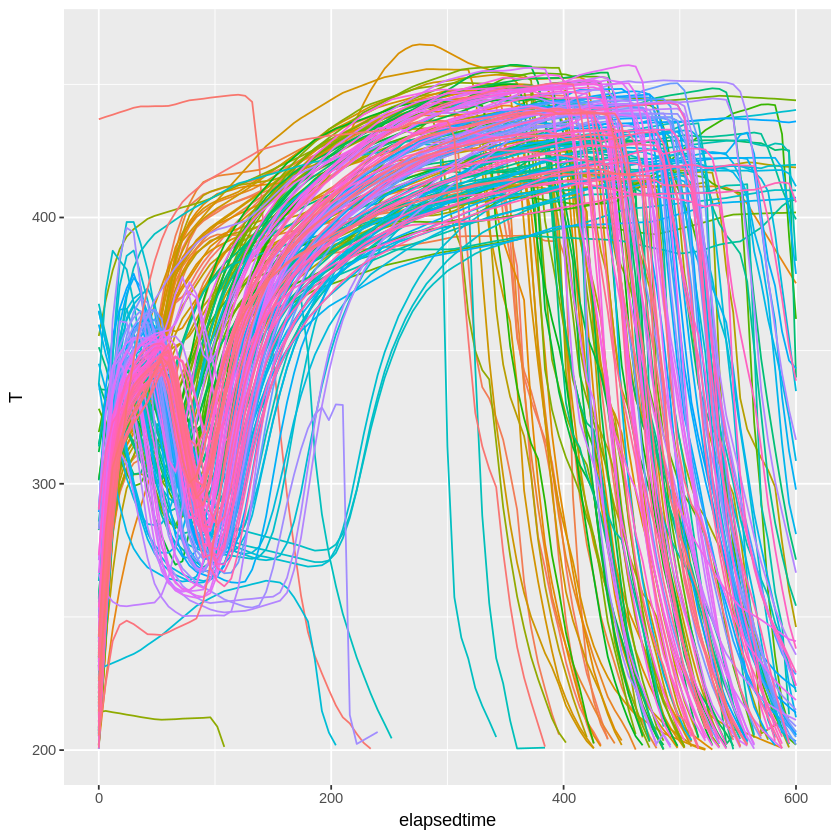

In [30]:
# Plot temperature vs time after adjusting the elapsed time vector. (step 3)
ggplot(data=C1)+aes(x=elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+theme(legend.position='none')+xlim(0,600)

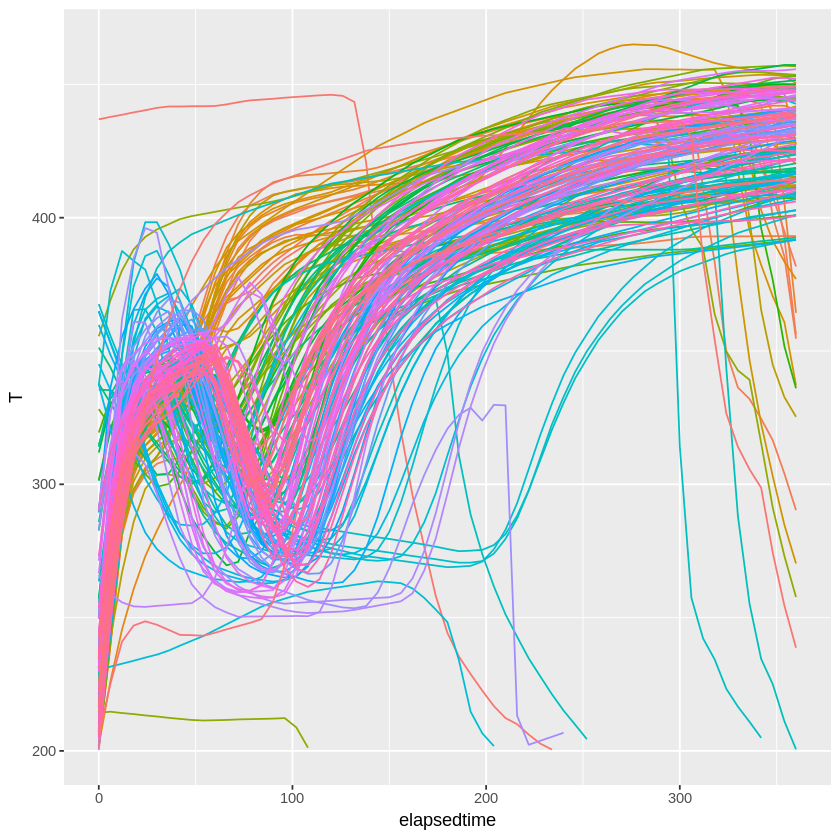

In [31]:
#keep records for only the first 6 hours of each cycle.(step 4)
C160=subset(C1,C1$elapsedtime<=360)
ggplot(data=C160)+aes(x=elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+theme(legend.position='none')+xlim(0,360)

In [32]:
time<- C160$elapsedtime 
C160["time"]<- time
# get aggregate values for each cycle
C160Runs=sqldf("select max(elapsedtime) as TimeMax,max(T) as Tmax,elapsedtime as TimeTMax,StartTime,Cycle from C160 group by Cycle", drv='SQLite')
nrow(C160Runs)

[1] 176

In [33]:
# View C160Runs.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
C160Runs

TimeMax Tmax  TimeTMax StartTime           Cycle
1   234     446.1 120      2017-01-02            1  
2   360     445.4 360      2017-01-02 19:00:00   2  
3   360     444.3 324      2017-01-03 21:18:00   3  
4   360     444.3 324      2017-01-04 22:54:00   4  
5   360     441.3 300      2017-01-05 19:54:00   5  
6   360     436.5 288      2017-01-06 20:54:00   6  
7   360     393.1 342      2017-01-07 21:06:00   7  
8   360     412.4 360      2017-01-08 22:24:00   8  
9   360     449.5 360      2017-01-10 03:12:00   9  
10  360     447.8 318      2017-01-11 02:36:00  10  
11  360     442.0 348      2017-01-12 04:18:00  11  
12  360     412.1 360      2017-01-13 03:00:00  12  
13  360     428.8 330      2017-01-14 13:30:00  13  
14  360     427.5 348      2017-01-15 17:24:00  14  
15  360     441.8 360      2017-01-16 21:42:00  15  
16  360     448.1 360      2017-01-17 23:30:00  16  
17  360     448.5 360      2017-01-19 02:24:00  17  
18  360     465.0 276      2017-01-20 06:30:00  18  
19  360     450.4 342      2017-01-21 15:36:00  19  
20  360     450.1 360      2017-01-23 01:30:00  20  
21  360     455.7 282      2017-01-24 07:42:00  21  
22  360     453.6 342      2017-01-25 08:48:00  22  
23  360     444.3 306      2017-01-26 11:18:00  23  
24  360     424.8 360      2017-01-27 15:06:00  24  
25  360     425.8 360      2017-01-28 18:00:00  25  
26  360     432.0 354      2017-01-29 19:06:00  26  
27  360     428.3 360      2017-01-30 21:30:00  27  
28  360     420.1 300      2017-01-31 22:06:00  28  
29  360     424.7 360      2017-02-02 00:30:00  29  
30  360     435.3 312      2017-02-03 01:18:00  30  
31  360     413.4 360      2017-02-04 22:00:00  31  
32  360     413.5 360      2017-02-06 23:36:00  32  
33  360     408.8 360      2017-02-08 22:54:00  33  
34  360     440.5 360      2017-02-11 06:12:00  34  
35  360     436.2 348      2017-02-14 15:48:00  35  
36  360     411.7 360      2017-02-17 16:36:00  37  
37  360     415.4 354      2017-02-20 12:48:00  38  
38  360     430.0 360      2017-02-23 10:18:00  40  
39  360     407.7 360      2017-03-04 22:48:00  42  
40  360     436.0 282      2017-03-14 08:00:00  43  
41  108     214.7   6      2017-03-14 23:00:00  44  
42  360     450.6 312      2017-03-17 21:54:00  45  
43  360     454.6 336      2017-03-20 14:30:00  46  
44  360     449.0 324      2017-03-22 14:36:00  47  
45  360     457.0 354      2017-03-24 22:12:00  48  
46  360     445.9 342      2017-03-27 01:30:00  49  
47  360     444.9 360      2017-03-29 22:06:00  50  
48  360     391.7 360      2017-03-31 23:48:00  51  
49  360     425.2 360      2017-04-03 00:30:00  52  
50  360     453.2 360      2017-04-05 01:30:00  53  
51  360     407.4 360      2017-04-07 05:18:00  54  
52  360     437.8 360      2017-04-08 23:42:00  55  
53  360     438.4 360      2017-04-10 17:18:00  56  
54  360     400.9 360      2017-04-12 05:06:00  57  
55  360     442.0 330      2017-04-13 21:18:00  58  
56  360     448.0 354      2017-04-15 12:00:00  59  
57  360     450.1 348      2017-04-17 02:18:00  60  
58  360     426.6 360      2017-04-18 11:00:00  61  
59  360     413.9 360      2017-04-20 06:36:00  62  
60  360     444.0 342      2017-04-21 16:18:00  63  
61  360     457.3 354      2017-04-23 08:06:00  64  
62  360     448.3 360      2017-04-24 22:36:00  65  
63  360     451.6 360      2017-04-26 11:30:00  66  
64  360     438.5 360      2017-04-27 16:30:00  67  
65  360     413.6 354      2017-04-29 06:48:00  68  
66  360     418.5 312      2017-04-30 18:12:00  69  
67  360     418.7 360      2017-05-02 06:42:00  70  
68  360     424.0 360      2017-05-03 22:42:00  71  
69  360     426.3 360      2017-05-05 16:54:00  72  
70  360     427.0 360      2017-05-07 11:48:00  73  
71  360     448.5 360      2017-05-09 06:24:00  74  
72  360     432.8 330      2017-05-10 22:48:00  75  
73  360     420.4 360      2017-05-12 09:00:00  76  
74  360     418.7 360      2017-05-13 19:36:00  77  
75  360     426.4 360      20

In [34]:
# select cycles that ran for at least 6 hours.(step 5)
C160RunsBasis=subset(C160Runs,C160Runs$TimeMax==360)
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
C160RunsBasis
nrow(C160RunsBasis)

TimeMax Tmax  TimeTMax StartTime           Cycle
2   360     445.4 360      2017-01-02 19:00:00   2  
3   360     444.3 324      2017-01-03 21:18:00   3  
4   360     444.3 324      2017-01-04 22:54:00   4  
5   360     441.3 300      2017-01-05 19:54:00   5  
6   360     436.5 288      2017-01-06 20:54:00   6  
7   360     393.1 342      2017-01-07 21:06:00   7  
8   360     412.4 360      2017-01-08 22:24:00   8  
9   360     449.5 360      2017-01-10 03:12:00   9  
10  360     447.8 318      2017-01-11 02:36:00  10  
11  360     442.0 348      2017-01-12 04:18:00  11  
12  360     412.1 360      2017-01-13 03:00:00  12  
13  360     428.8 330      2017-01-14 13:30:00  13  
14  360     427.5 348      2017-01-15 17:24:00  14  
15  360     441.8 360      2017-01-16 21:42:00  15  
16  360     448.1 360      2017-01-17 23:30:00  16  
17  360     448.5 360      2017-01-19 02:24:00  17  
18  360     465.0 276      2017-01-20 06:30:00  18  
19  360     450.4 342      2017-01-21 15:36:00  19  
20  360     450.1 360      2017-01-23 01:30:00  20  
21  360     455.7 282      2017-01-24 07:42:00  21  
22  360     453.6 342      2017-01-25 08:48:00  22  
23  360     444.3 306      2017-01-26 11:18:00  23  
24  360     424.8 360      2017-01-27 15:06:00  24  
25  360     425.8 360      2017-01-28 18:00:00  25  
26  360     432.0 354      2017-01-29 19:06:00  26  
27  360     428.3 360      2017-01-30 21:30:00  27  
28  360     420.1 300      2017-01-31 22:06:00  28  
29  360     424.7 360      2017-02-02 00:30:00  29  
30  360     435.3 312      2017-02-03 01:18:00  30  
31  360     413.4 360      2017-02-04 22:00:00  31  
32  360     413.5 360      2017-02-06 23:36:00  32  
33  360     408.8 360      2017-02-08 22:54:00  33  
34  360     440.5 360      2017-02-11 06:12:00  34  
35  360     436.2 348      2017-02-14 15:48:00  35  
36  360     411.7 360      2017-02-17 16:36:00  37  
37  360     415.4 354      2017-02-20 12:48:00  38  
38  360     430.0 360      2017-02-23 10:18:00  40  
39  360     407.7 360      2017-03-04 22:48:00  42  
40  360     436.0 282      2017-03-14 08:00:00  43  
42  360     450.6 312      2017-03-17 21:54:00  45  
43  360     454.6 336      2017-03-20 14:30:00  46  
44  360     449.0 324      2017-03-22 14:36:00  47  
45  360     457.0 354      2017-03-24 22:12:00  48  
46  360     445.9 342      2017-03-27 01:30:00  49  
47  360     444.9 360      2017-03-29 22:06:00  50  
48  360     391.7 360      2017-03-31 23:48:00  51  
49  360     425.2 360      2017-04-03 00:30:00  52  
50  360     453.2 360      2017-04-05 01:30:00  53  
51  360     407.4 360      2017-04-07 05:18:00  54  
52  360     437.8 360      2017-04-08 23:42:00  55  
53  360     438.4 360      2017-04-10 17:18:00  56  
54  360     400.9 360      2017-04-12 05:06:00  57  
55  360     442.0 330      2017-04-13 21:18:00  58  
56  360     448.0 354      2017-04-15 12:00:00  59  
57  360     450.1 348      2017-04-17 02:18:00  60  
58  360     426.6 360      2017-04-18 11:00:00  61  
59  360     413.9 360      2017-04-20 06:36:00  62  
60  360     444.0 342      2017-04-21 16:18:00  63  
61  360     457.3 354      2017-04-23 08:06:00  64  
62  360     448.3 360      2017-04-24 22:36:00  65  
63  360     451.6 360      2017-04-26 11:30:00  66  
64  360     438.5 360      2017-04-27 16:30:00  67  
65  360     413.6 354      2017-04-29 06:48:00  68  
66  360     418.5 312      2017-04-30 18:12:00  69  
67  360     418.7 360      2017-05-02 06:42:00  70  
68  360     424.0 360      2017-05-03 22:42:00  71  
69  360     426.3 360      2017-05-05 16:54:00  72  
70  360     427.0 360      2017-05-07 11:48:00  73  
71  360     448.5 360      2017-05-09 06:24:00  74  
72  360     432.8 330      2017-05-10 22:48:00  75  
73  360     420.4 360      2017-05-12 09:00:00  76  
74  360     418.7 360      2017-05-13 19:36:00  77  
75  360     426.4 360      2017-05-15 14:42:00  78  
76  360     416.3 360      2017-05-16 18:00:00  79  
77  360     418.0 360      20

[1] 170

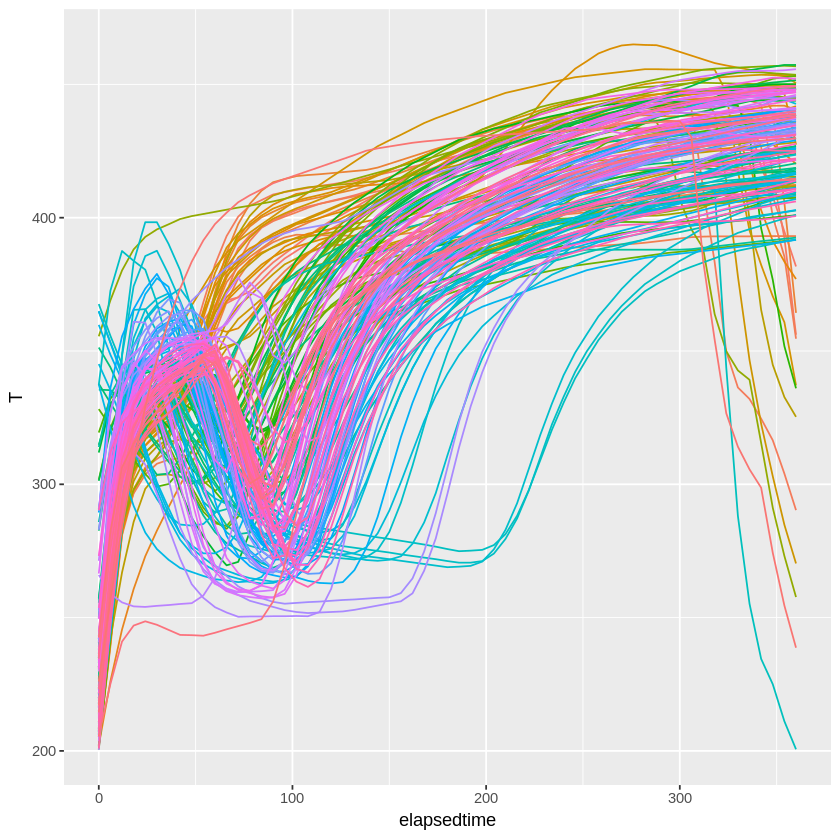

In [35]:
# Create a C160Basis (step 5)
C160Basis=subset(C160,C160$Cycle %in% C160RunsBasis$Cycle)
ggplot(data=C160Basis)+aes(x=elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+theme(legend.position='none')


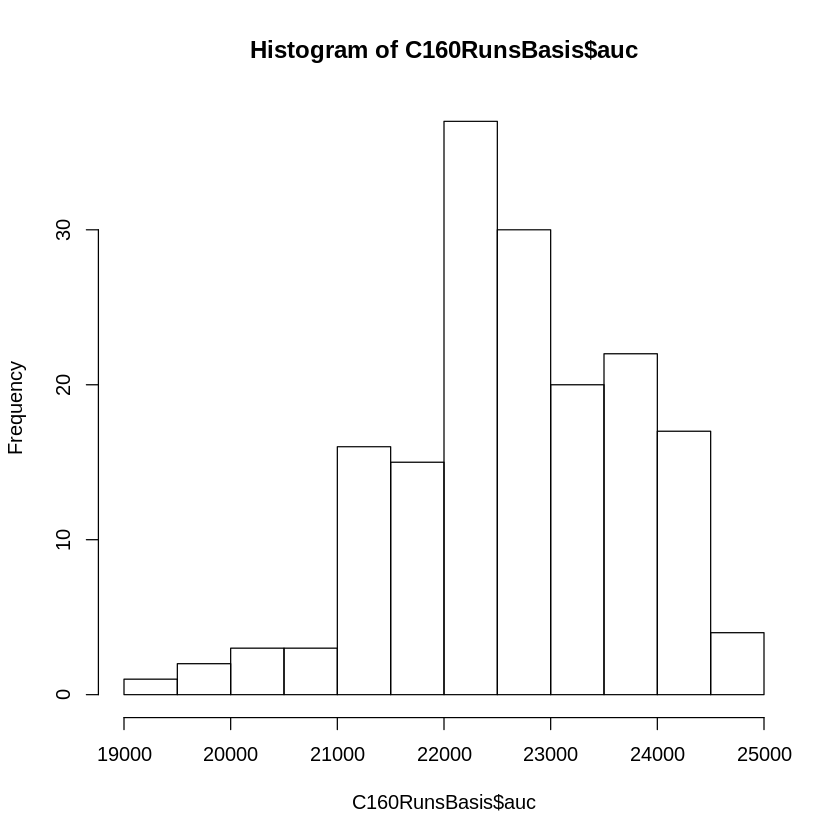

In [36]:
#auc (Area Under the Curve) (step 5-6)
C160RunsBasis$auc=0
for (j in 1:nrow(C160RunsBasis)){
 
  k=C160RunsBasis$Cycle[j]
  CfRun=data.matrix(subset(C160Basis,Cycle==k & elapsedtime<=360)$T)
  C160RunsBasis$auc[j]=auc(c(1:length(CfRun)),CfRun,type='spline')  #note there are 361 rows per Cycle (time=0 to time=360)
}
# add this line in case the hist command gives an error: " figure margine too large" 
#par(mar=c(1,1,1,1)) 
hist(C160RunsBasis$auc)

In [37]:
# Step 6
C160RunsBasisOrder=C160RunsBasis[order(C160RunsBasis$auc),]
nrow(C160RunsBasisOrder)

[1] 170

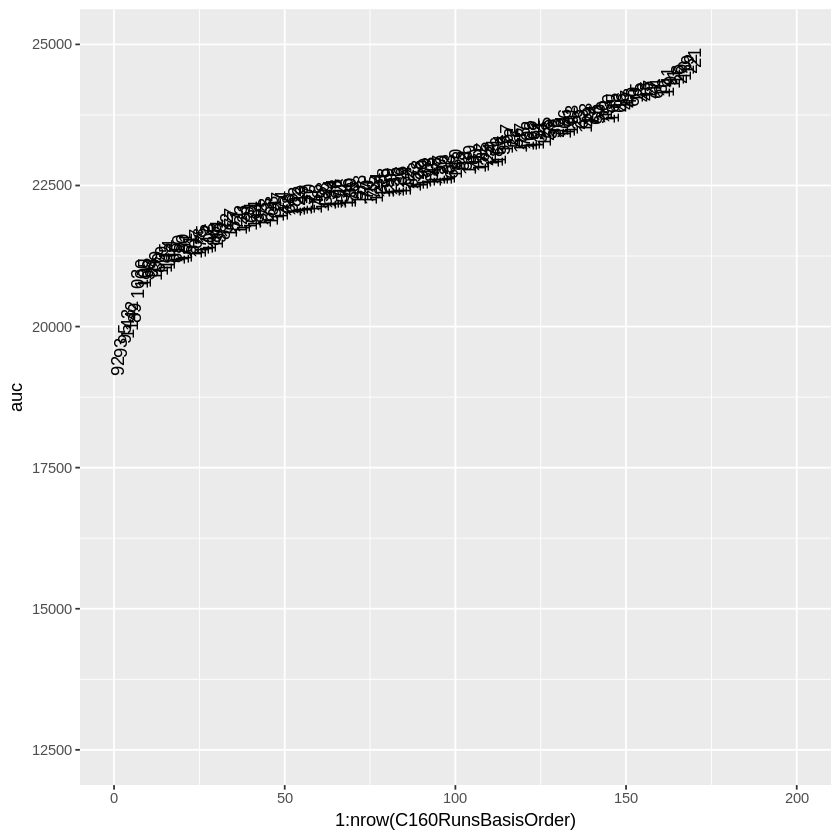

In [38]:
# Step 6
ggplot(data=C160RunsBasisOrder) + aes(1:nrow(C160RunsBasisOrder), auc) +geom_text(label=C160RunsBasisOrder$Cycle,angle=-270)+xlim(0,200)+ylim(12500,25000)

In [39]:
#pick middle 50% i.e. all runs between 25% and 75% (step 7)
indexStart=as.integer(nrow(C160RunsBasisOrder)/4)
indexEnd=as.integer(nrow(C160RunsBasisOrder)/4)*3
indexStart
indexEnd

[1] 42

[1] 126

In [40]:
# Filter the data to keep only the 50% middle. (Step 7)
C160RunsBasisOrderMidQ=C160RunsBasisOrder[indexStart:indexEnd,]
nrow(C160RunsBasisOrderMidQ)

C160BasisOrderMidQ=subset(C160Basis,Cycle %in% C160RunsBasisOrderMidQ$Cycle)

[1] 85

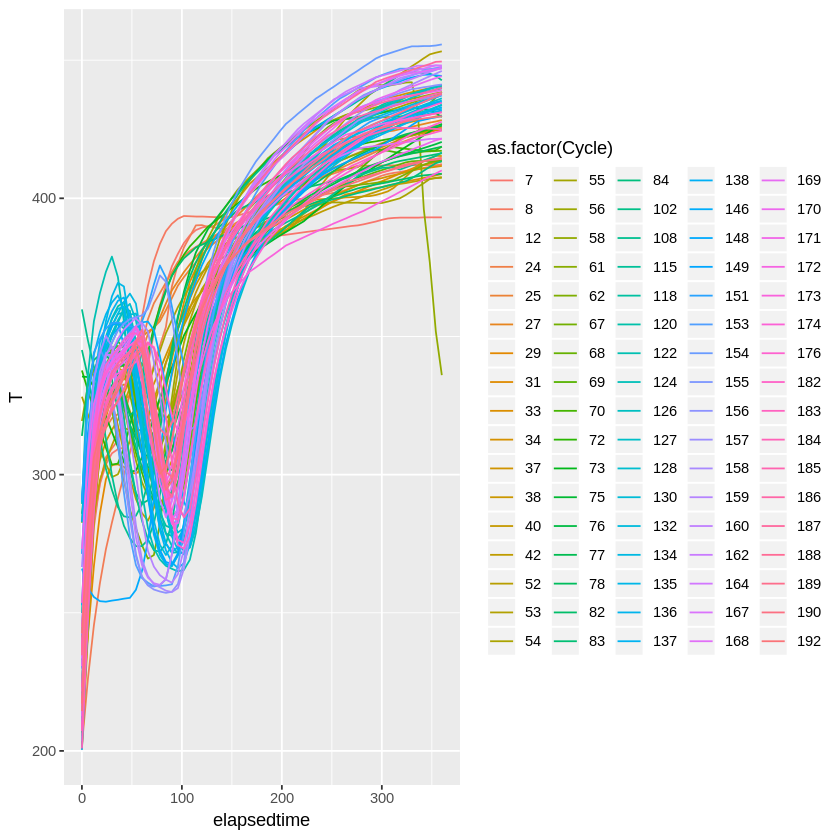

In [41]:
ggplot(data=C160BasisOrderMidQ)+aes(x=elapsedtime,y=T)+geom_line(aes(color=as.factor(Cycle)))+xlim(0,360)

In [42]:
# Find the golden run and plot it (step 9)
CTGold=C160BasisOrderMidQ %>% group_by(elapsedtime) %>% summarise(Outlet.Temperature=mean(Outlet.Temperature))
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
CTGold

elapsedtime Outlet.Temperature
1    0         240.0671          
2    6         279.6482          
3   12         308.8788          
4   18         323.9953          
5   24         331.3059          
6   30         334.3776          
7   36         334.7400          
8   42         333.3612          
9   48         330.6435          
10  54         327.3388          
11  60         323.1376          
12  66         317.7576          
13  72         312.6824          
14  78         308.6894          
15  84         306.8141          
16  90         308.3318          
17  96         313.1118          
18 102         320.3518          
19 108         329.3576          
20 114         339.1376          
21 120         348.5812          
22 126         356.9894          
23 132         364.1671          
24 138         370.1929          
25 144         375.3059          
26 150         379.6365          
27 156         383.3800          
28 162         386.6918          
29 168         389.6471          
30 174         392.2341          
31 180         394.6365          
32 186         396.9059          
33 192         398.9953          
34 198         400.9753          
35 204         402.8718          
36 210         404.6847          
37 216         406.4529          
38 222         408.1565          
39 228         409.8306          
40 234         411.4224          
41 240         412.9188          
42 246         414.3459          
43 252         415.6788          
44 258         416.9200          
45 264         418.0941          
46 270         419.2082          
47 276         420.2647          
48 282         421.2247          
49 288         422.1294          
50 294         422.9953          
51 300         423.8141          
52 306         424.5929          
53 312         425.3447          
54 318         426.0647          
55 324         426.7624          
56 330         427.4459          
57 336         427.9282          
58 342         428.1153          
59 348         428.4459          
60 354         428.6576          
61 360         428.9141

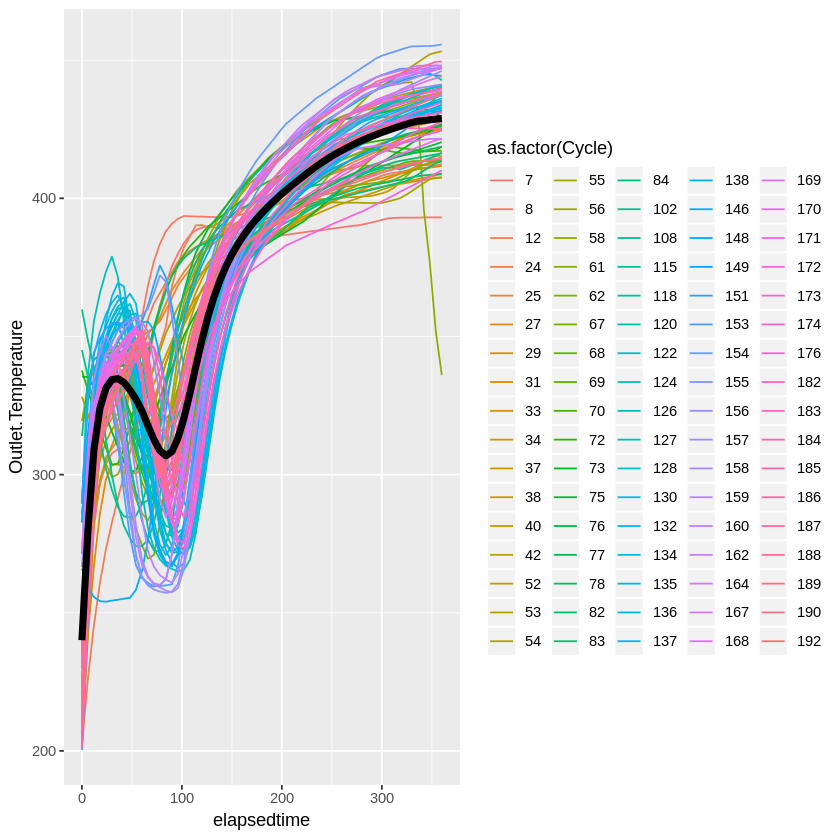

In [43]:
# plot of the Golden Run.(step 10)
ggplot(data=C160BasisOrderMidQ)+aes(x=elapsedtime,y=Outlet.Temperature)+geom_line(aes(color=as.factor(Cycle))) +geom_line(data=CTGold, size=2)+xlim(0,360)

In [44]:
# Step 11
new<-subset(C160BasisOrderMidQ,select=c("T","elapsedtime","Cycle"))

In [45]:
# Step 11
#Find the closest run to the Golden Run by least squares.new<-subset(C160BasisOrderMidQ,select=c("T","elapsedtime","Cycle"))
new$Gold= CTGold$Outlet.Temperature
# Square  the difference of the temperature between the Golden Run and the temperature.
new$difference=(new$Gold-new$T)^2
new
# Group these squares by Cycle and Take the sum of the squares. 
closest=new %>% group_by(Cycle) %>% summarise (squares=sum(difference))
# Find the minimum of these sums.
closestsquare=min(closest$squares)
closestsquare %in% closest$squares
# Match the smallest square value to the cycle number it corresponds to.
ind=match(closestsquare,closest$squares)
Cycleclosest=closest$Cycle[32]

T     elapsedtime Cycle Gold     difference  
529   224.4   0          7    240.0671 2.454567e+02
530   259.5   6          7    279.6482 4.059514e+02
531   283.4  12          7    308.8788 6.491704e+02
532   296.6  18          7    323.9953 7.505021e+02
533   303.7  24          7    331.3059 7.620847e+02
534   307.7  30          7    334.3776 7.116969e+02
535   309.2  36          7    334.7400 6.522916e+02
536   309.8  42          7    333.3612 5.551290e+02
537   311.6  48          7    330.6435 3.626560e+02
538   318.6  54          7    327.3388 7.636704e+01
539   328.5  60          7    323.1376 2.875483e+01
540   339.4  66          7    317.7576 4.683914e+02
541   351.6  72          7    312.6824 1.514583e+03
542   361.2  78          7    308.6894 2.757362e+03
543   368.7  84          7    306.8141 3.829862e+03
544   375.4  90          7    308.3318 4.498148e+03
545   379.9  96          7    313.1118 4.460668e+03
546   383.8 102          7    320.3518 4.025679e+03
547   386.6 108          7    329.3576 3.276687e+03
548   388.5 114          7    339.1376 2.436642e+03
549   389.4 120          7    348.5812 1.666176e+03
550   389.9 126          7    356.9894 1.083107e+03
551   389.5 132          7    364.1671 6.417579e+02
552   389.0 138          7    370.1929 3.537055e+02
553   388.6 144          7    375.3059 1.767336e+02
554   388.1 150          7    379.6365 7.163133e+01
555   387.4 156          7    383.3800 1.616040e+01
556   386.7 162          7    386.6918 6.782007e-05
557   386.0 168          7    389.6471 1.330104e+01
558   385.4 174          7    392.2341 4.670516e+01
559   385.7 180          7    394.6365 7.986051e+01
560   386.0 186          7    396.9059 1.189383e+02
561   386.3 192          7    398.9953 1.611705e+02
562   386.5 198          7    400.9753 2.095341e+02
563   386.8 204          7    402.8718 2.583016e+02
564   387.1 210          7    404.6847 3.092219e+02
565   387.4 216          7    406.4529 3.630146e+02
566   387.7 222          7    408.1565 4.184672e+02
567   388.0 228          7    409.8306 4.765746e+02
568   388.3 234          7    411.4224 5.346432e+02
569   388.5 240          7    412.9188 5.962789e+02
570   388.8 246          7    414.3459 6.525921e+02
571   389.1 252          7    415.6788 7.064339e+02
572   389.4 258          7    416.9200 7.573504e+02
573   389.7 264          7    418.0941 8.062259e+02
574   390.0 270          7    419.2082 8.531210e+02
575   390.2 276          7    420.2647 9.038865e+02
576   390.6 282          7    421.2247 9.378726e+02
577   391.1 288          7    422.1294 9.628244e+02
578   391.6 294          7    422.9953 9.856645e+02
579   392.2 300          7    423.8141 9.994524e+02
580   392.7 306          7    424.5929 1.017160e+03
581   392.9 312          7    425.3447 1.052659e+03
582   393.0 318          7    426.0647 1.093275e+03
583   393.0 324          7    426.7624 1.139896e+03
584   393.0 330          7    427.4459 1.186519e+03
585   393.0 336          7    427.9282 1.219982e+03
586   393.1 342          7    428.1153 1.226071e+03
587   393.1 348          7    428.4459 1.249331e+03
588   393.1 354          7    428.6576 1.264346e+03
589   393.1 360          7    428.9141 1.282651e+03
622   205.3   0          8    240.0671 1.208748e+03
623   243.3   6          8    279.6482 1.321194e+03
624   280.9  12          8    308.8788 7.828146e+02
625   297.0  18          8    323.9953 7.287459e+02
626   306.3  24          8    331.3059 6.252942e+02
627   309.5  30          8    334.3776 6.188973e+02
628   312.4  36          8    334.7400 4.990756e+02
629   319.2  42          8    333.3612 2.005389e+02
630   330.0  48          8    330.6435 4.141301e-01
631   343.0  54          8    327.3388 2.452724e+02
632   356.8  60          8    323.1376 1.133154e+03
633   368.3  66          8    317.7576 2.554529e+03
634   377.2  72          8    312.6824 4.162527e+03
635   383.5  78          8    308.6894 5.596624e+03
636   388.1  84          8    306.8141 6.607395e+03
63

[1] TRUE

In [46]:
# Step 11
# Display the closest cycle value.
Cycleclosest

[1] 78

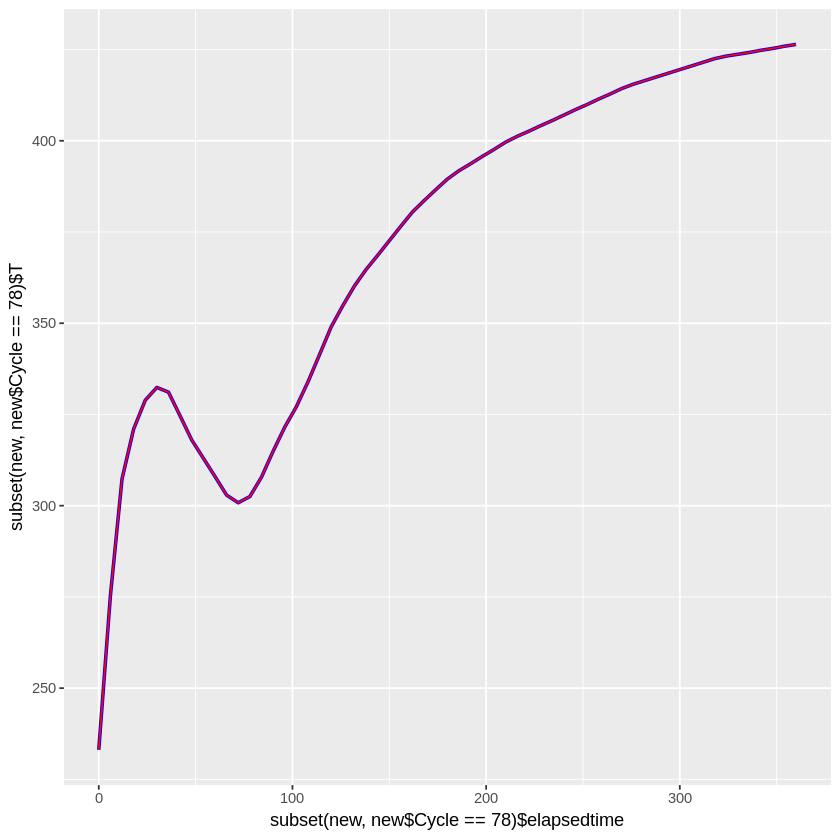

In [47]:
# Plot the closest run (in blue) as well as the golden run (in red).
ggplot((data=subset(new,new$Cycle==78)))+aes(x=subset(new,new$Cycle==78)$elapsedtime,y=subset(new,new$Cycle==78)$T)+geom_line(size=1,color="Blue")+geom_line(data=CTGold,size=0.5,color="red")